In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
#Task 1 - Part 1
def clean_data(df):
    #Takes in a pyspark dataframe
    #Counts number of entries before and after dropping duplicates,
    #nulls and missing values.
    print(f'Original count {df.count()}')
    df = df.dropDuplicates()
    df = df.dropna()
    print(f'New count {df.count()}')
    return df

df = spark.read.csv('nuclear_plants_small_dataset.csv',inferSchema=True,header=True)
df = clean_data(df)

Original count 996
New count 996


Normal group summary statistics:
+---------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|Statistic|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4| Pressure_sensor_1| Pressure_sensor_2|Pressure_sensor_3|Pressure_sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+---------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|     mean|   5.602452811244987|   6.844503413654614|    9.292054016064252|   8.701398192771098|13.797525502008027|3.4156463855421686|5.923352610441763|5.586180120481918| 8.441436947791164| 9.699615863453817|  19.4378044176707

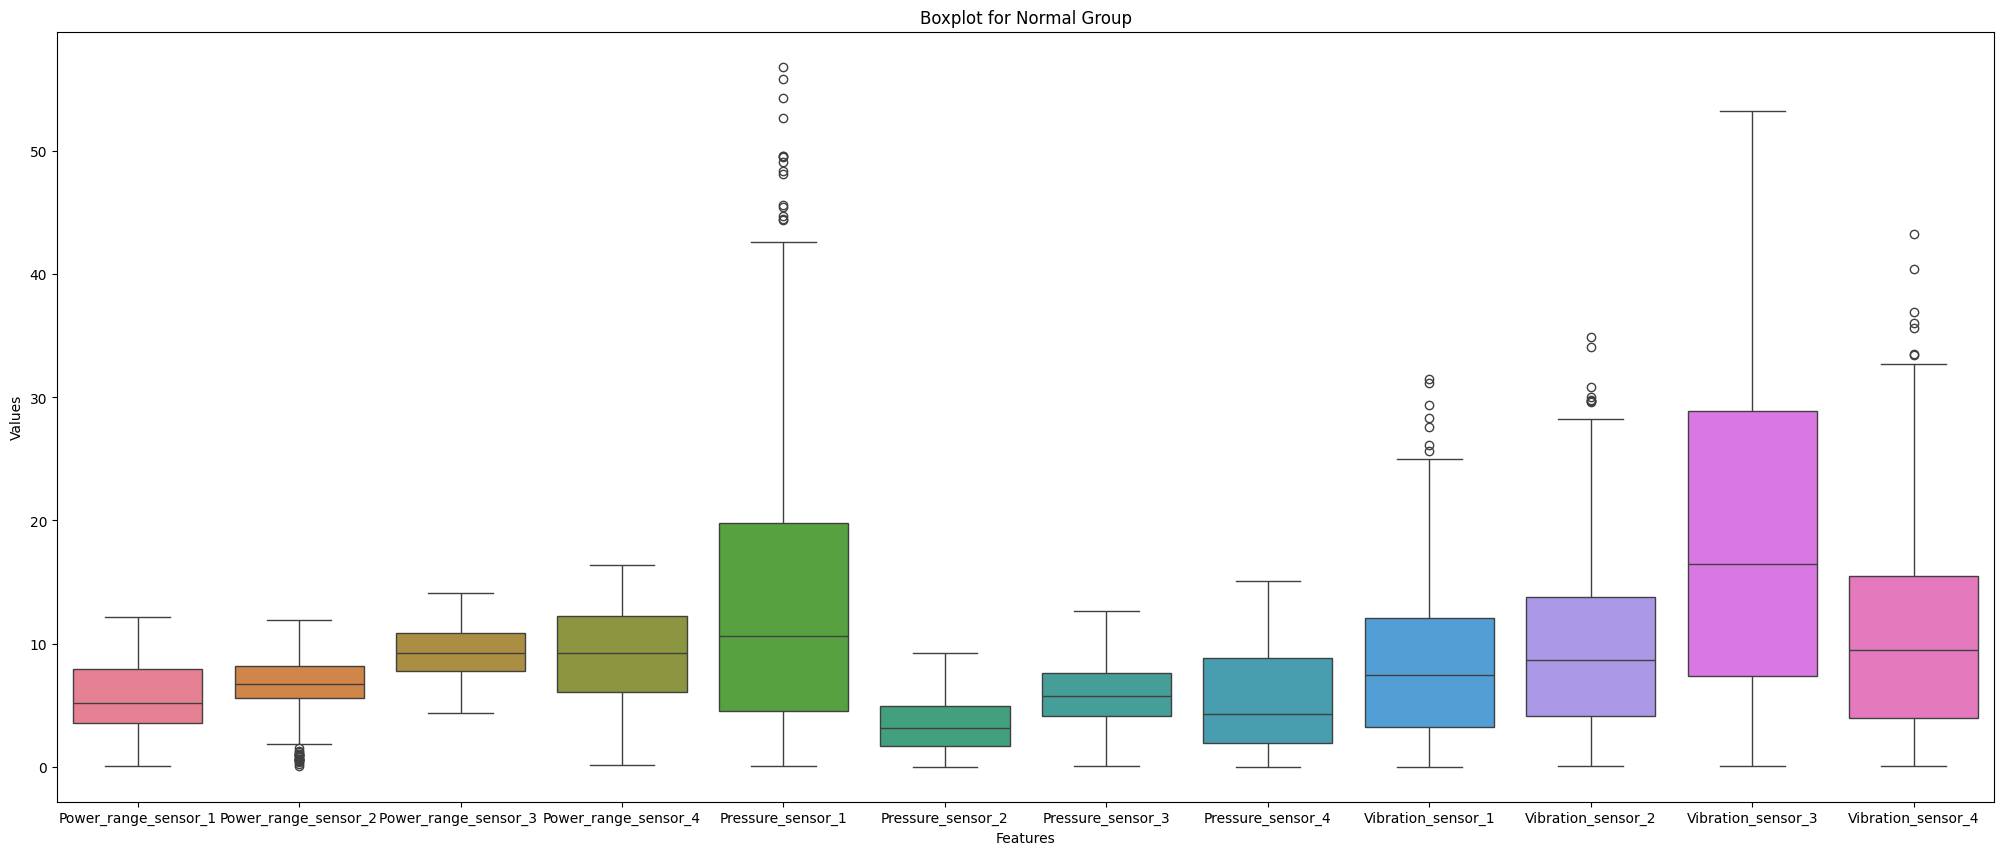

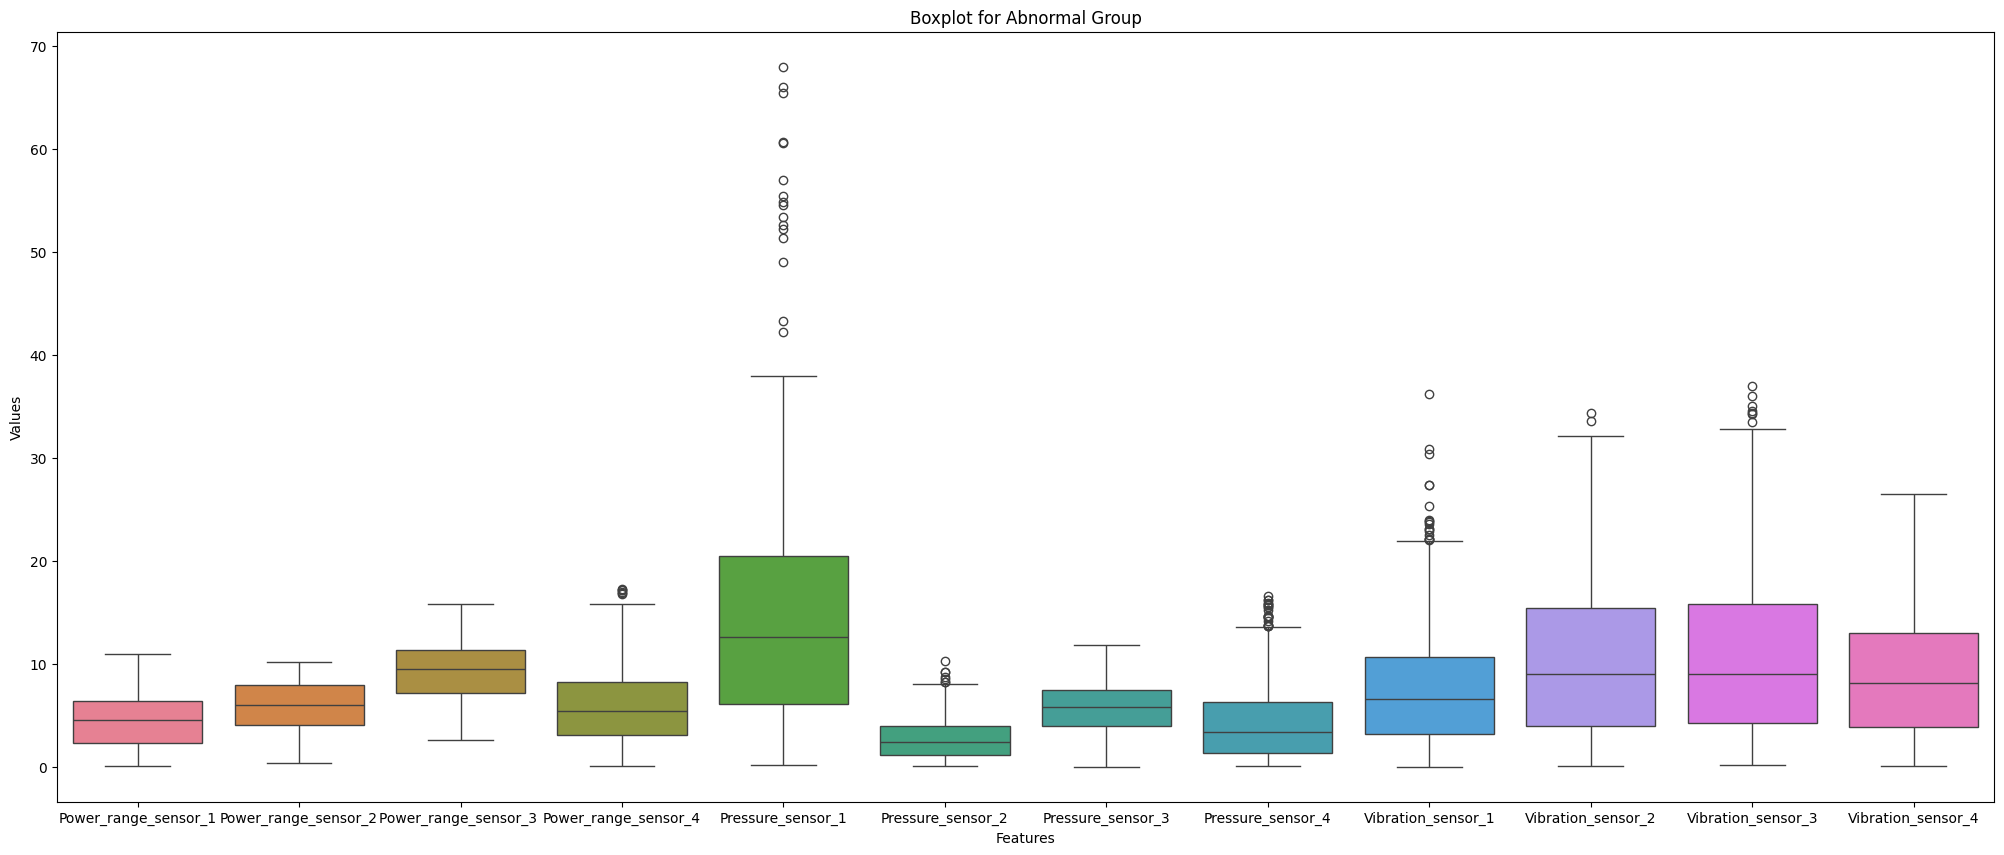

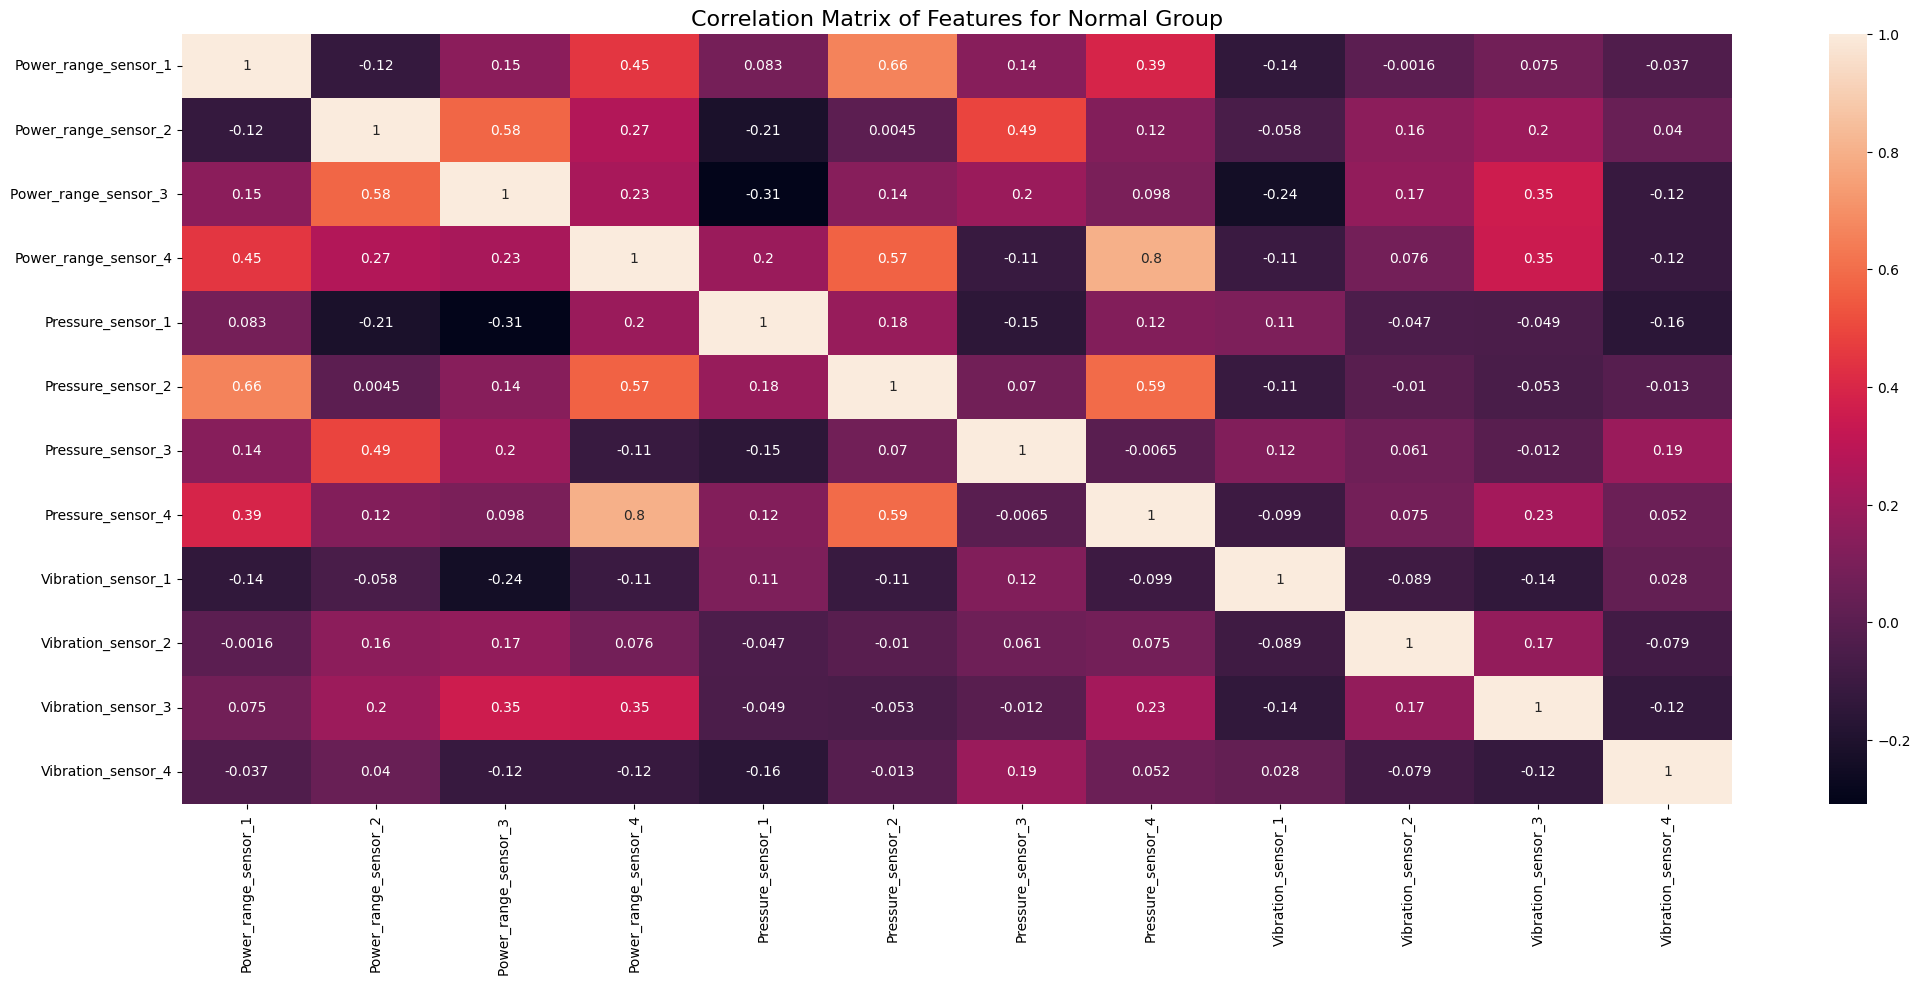

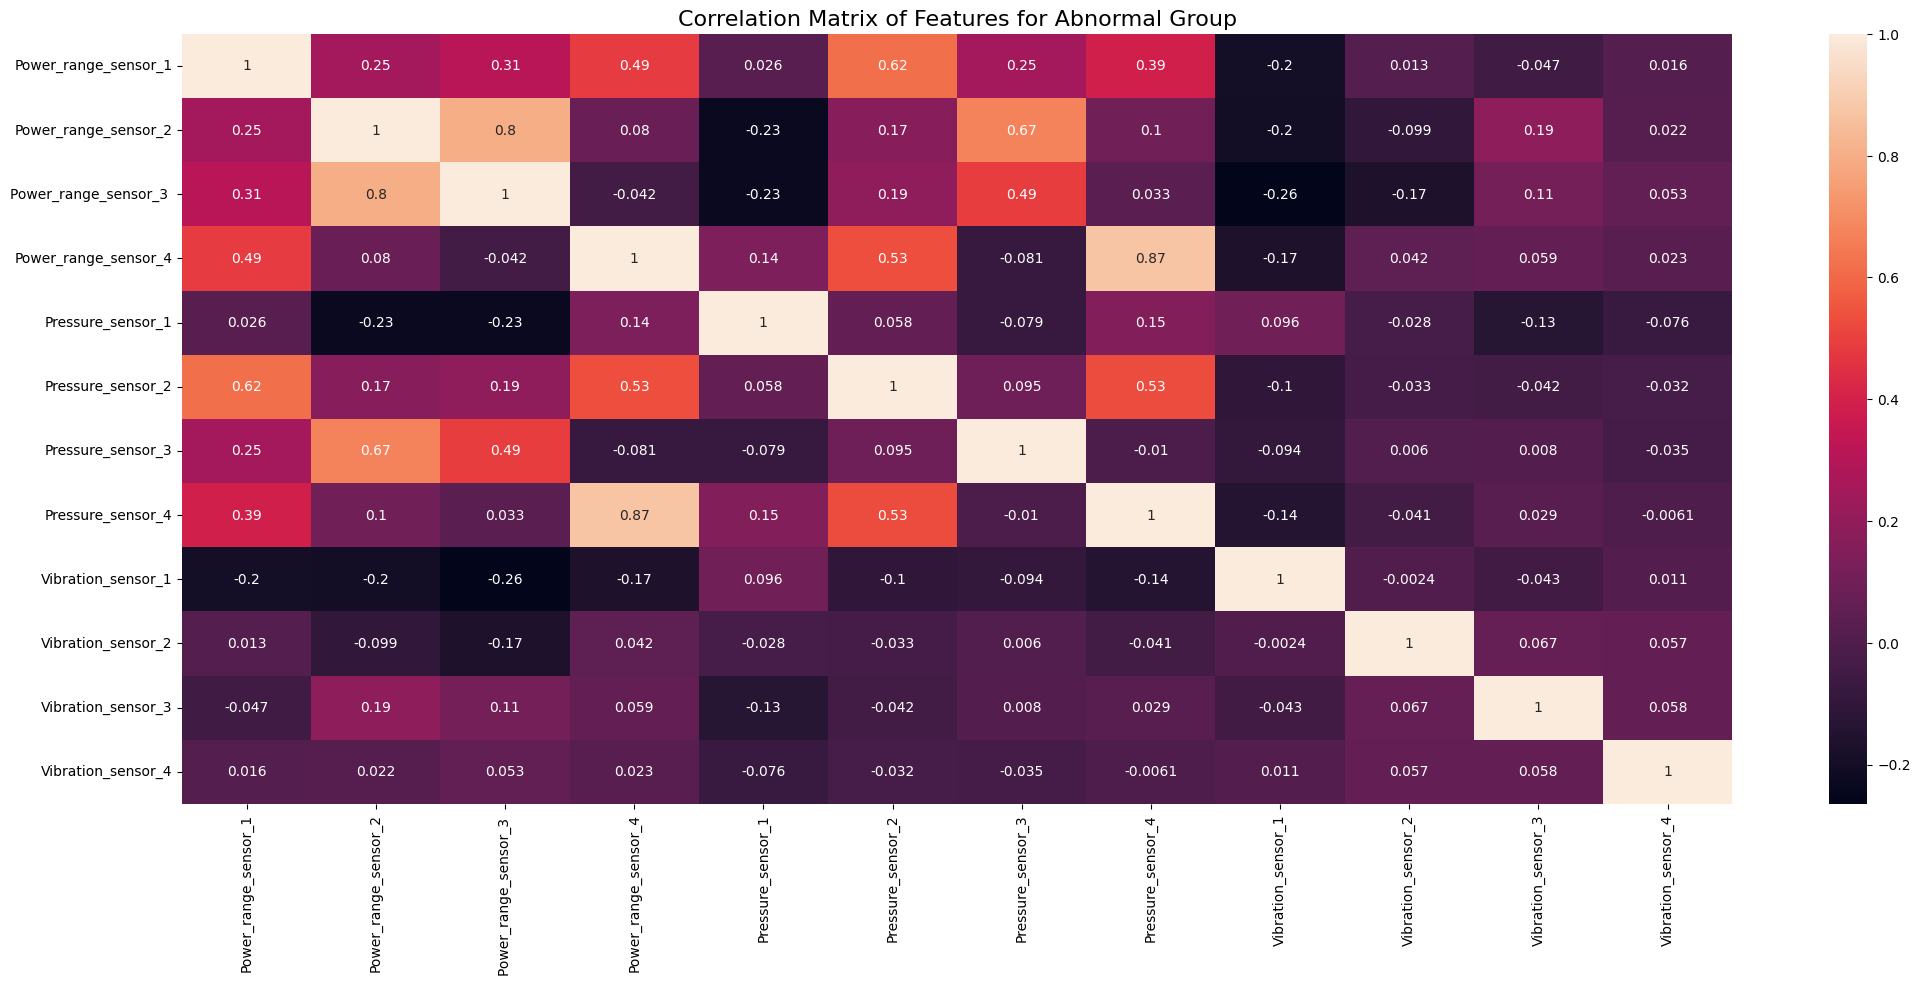

In [4]:
#Task 1 - Part 2 and 3

def filter_df(df):
    #Filters dataframe by normal and abnormal groups
    #Returns two dataframes, one for each group.
    normal_df = df.filter(df['Status'] == 'Normal')
    abnormal_df = df.filter(df['Status'] == 'Abnormal')

    return normal_df, abnormal_df


def summary_stats(df):
    #Takes in pyspark dataframe
    #Drops the status column and uses .summary to find mean min max and median, renames the 50% to median
    #Then converts to a pandas dataframe.
    
    normal_df, abnormal_df = filter_df(df)


    dfSummaryNormal = normal_df.drop('Status').summary('mean','min','max','50%')
    dfSummaryNormal = dfSummaryNormal.withColumnRenamed("50%","median")\
                            .withColumnRenamed('summary', 'Statistic')
    
    dfSummaryAbnormal = abnormal_df.drop('Status').summary('mean','min','max','50%')
    dfSummaryAbnormal = dfSummaryAbnormal.withColumnRenamed("50%","median")\
                            .withColumnRenamed('summary', 'Statistic')
    
    return dfSummaryNormal, dfSummaryAbnormal


def boxplot_df(df):
    #Takes in pyspark dataframe filters to normal and abnormal groups, converts to pandas dataframe
    #and plots a boxplot for each feature in each group.

    #Filter the dataframe by normal and abnormal groups
    normal_df, abnormal_df = filter_df(df)

    if normal_df:
        normal_df = normal_df.toPandas()
        #Drop the status column
        normal_df.drop('Status',axis=1,inplace=True)
        plt.figure(figsize=(25,10))
        sns.boxplot(data=normal_df)
        plt.ylabel('Values')
        plt.xlabel('Features')
        plt.title('Boxplot for Normal Group')
        plt.show()
    if abnormal_df:
        abnormal_df = abnormal_df.toPandas()
        #Drop the status column
        abnormal_df.drop('Status',axis=1,inplace=True)
        plt.figure(figsize=(25,10))
        sns.boxplot(data=abnormal_df)
        plt.ylabel('Values')
        plt.xlabel('Features')
        plt.title('Boxplot for Abnormal Group')
        plt.show()

summaryNormal, summaryAbnormal = summary_stats(df)
print('Normal group summary statistics:')
summaryNormal.show()

print('Abnormal group summary statistics:')
summaryAbnormal.show()

boxplot_df(df)


#Creating correlation matrix for normal and abnormal groups
normal, abnormal = filter_df(df)
normal = normal.drop('Status').toPandas()
abnormal = abnormal.drop('Status').toPandas()

corr_matrix_normal = normal.corr()
corr_matrix_abnormal = abnormal.corr()

#Visualising correlation matrix for both groups
plt.figure(figsize=(25,10))
plt.title('Correlation Matrix of Features for Normal Group',y=1,size=16)
sns.heatmap(corr_matrix_normal,annot = True)
plt.show()

plt.figure(figsize=(25,10))
plt.title('Correlation Matrix of Features for Abnormal Group',y=1,size=16)
sns.heatmap(corr_matrix_abnormal,annot = True)
plt.show()

In [5]:
#Task 2 - Map Reduce
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
#Task 2 - Part 1

airport_names = spark.read.csv('Top30_airports_LatLong.csv',inferSchema=True,)
airport_names = airport_names.withColumnRenamed('_c0','airportName')\
        .withColumnRenamed('_c1','Code')\
        .withColumnRenamed('_c2','Latitude')\
        .withColumnRenamed('_c3','Longitude')

passenger_data = spark.read.csv('AComp_Passenger_data_no_error.csv',inferSchema=True)
passenger_data = passenger_data.withColumnRenamed('_c0','passengerID')\
        .withColumnRenamed('_c1','flightID')\
        .withColumnRenamed('_c2','Origin_Code')\
        .withColumnRenamed('_c3','Destination_Code')\
        .withColumnRenamed('_c4','departureTime_GMT')\
        .withColumnRenamed('_c5','totalFlightTime_mins')

#join the airport names to the passenger data
passenger_data = passenger_data.join(airport_names,passenger_data.Origin_Code == airport_names.Code)
passenger_data = passenger_data.drop('Code').drop('Latitude').drop('Longitude')


#Count the number of flights from each airport
passenger_data_rdd = sc.parallelize(passenger_data.collect())
passenger_data_rdd = passenger_data_rdd.map(lambda x: (x[-1],1))
passenger_data_rdd = passenger_data_rdd.reduceByKey(lambda x,y: x+y)
passenger_data_rdd = passenger_data_rdd.sortBy(lambda x: x[1],ascending=False)
passenger_data_rdd = passenger_data_rdd.collect()
passenger_data_rdd = pd.DataFrame(passenger_data_rdd,columns=['Airport_Name','Number of Flights'])

In [6]:
print('Number of flights from each airport:')
print(passenger_data_rdd)

Number of flights from each airport:
         Airport_Name  Number of Flights
0              DENVER                 46
1             HOUSTON                 37
2           GUANGZHOU                 37
3             ATLANTA                 36
4             CHICAGO                 33
5        KUALA LUMPUR                 33
6             JAKARTA                 27
7              LONDON                 25
8            NEW YORK                 25
9           CHARLOTTE                 21
10              PARIS                 21
11           SHANGHAI                 20
12          LAS VEGAS                 17
13            BANGKOK                 17
14          AMSTERDAM                 15
15               ROME                 15
16             MUNICH                 14
17              TOKYO                 13
18             MADRID                 13
19            BEIJING                 13
20  DALLAS/FORT WORTH                 11
21              MIAMI                 11


In [7]:
#Create a list of unused airports using mapreduce
unused_airports = airport_names.select('airportName').subtract(passenger_data.select('airportName'))
unused_airports = unused_airports.collect()
unused_airports = pd.DataFrame(unused_airports,columns=['Airport_Name'])
print('Unused airports:')
print(unused_airports)


Unused airports:
    Airport_Name
0       ISTANBUL
1        PHOENIX
2          DUBAI
3      FRANKFURT
4      SINGAPORE
5      HONG KONG
6    LOS ANGELES
7  SAN FRANCISCO


In [8]:
#Task 2 - Part 2
#Create a list of flights based on the Flight id; including number of passengers, relevant IATA/FAA 
#codes, and departure and arrival times (times converted to HH:MM format)

passenger_count = passenger_data.groupBy("flightId", "Origin_Code", "Destination_Code").agg(
        F.countDistinct("PassengerId").alias("PassengerCount"),
        F.first(F.from_unixtime("departureTime_GMT")).alias("departureTime_GMT")
        )

passenger_count.show()

+--------+-----------+----------------+--------------+-------------------+
|flightId|Origin_Code|Destination_Code|PassengerCount|  departureTime_GMT|
+--------+-----------+----------------+--------------+-------------------+
|ATT7791R|        AMS|             DEN|            12|2015-01-06 17:13:14|
|BER7172M|        KUL|             LAS|            12|2015-01-06 17:26:07|
|DAU2617A|        CGK|             SFO|            12|2015-01-06 17:23:06|
|DKZ3042O|        MIA|             SFO|            10|2015-01-06 17:05:27|
|EWH6301Y|        CAN|             DFW|             7|2015-01-06 17:22:47|
|FYL5866L|        ATL|             HKG|            14|2015-01-06 17:25:40|
|GMO5938W|        LHR|             PEK|            17|2015-01-06 17:11:57|
|HUR0974O|        DEN|             PVG|             6|2015-01-06 17:15:25|
|HZT2506M|        IAH|             AMS|            10|2015-01-06 17:12:04|
|JVY9791G|        PVG|             FCO|            17|2015-01-06 17:16:01|
|KJR6646J|        IAH|   